<a href="https://colab.research.google.com/github/LsrkMateo/Identificador-de-parqueaderos/blob/main/Clasificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuracion inicial

## Importacion de modulos y dataset

Modulos `tensorflow`, `cv2`, `datasets` y `pylot`. Datos y metadatos desde dataset  `sun392`


In [ ]:
import tensorflow as tf
import cv2

from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

datos, metadatos = tfds.load('sun397', with_info=True)

Si deseas ver los metadatos del dataset ejecuta el siguiente codigo:

In [ ]:
print(metadatos)

## Analizar dict_key

Analizar como extaer la informacion del dataset: corresponde a la estructura de caracteristicas del dataset


In [ ]:

sample_element = next(iter(datos['train']))
print(sample_element.keys())


dict_keys(['file_name', 'image', 'label'])


## Filtrar archvios de interes

El dataset tiene 397 categorias, de ahi su nombre, por lo que se extrajo el indice de la etiquetas de interes ("/p/parking_garage/indoor", "/p/parking_garage/outdoor", y "/p/parking_lot") para asi filtrar los datos y entrenar le modelo para solo reconocer clases de parqueaderos.



In [ ]:
target_labels = [266, 267, 268]  # Las etiquetas correspondientes a "/p/parking_garage/indoor", "/p/parking_garage/outdoor", y "/p/parking_lot"

# Filtrar los datos para incluir solo las etiquetas de interés
def filter_func(x):
    return tf.reduce_any(tf.equal(x['label'], target_labels))

datos_entrenamiento_filtrados = datos['train'].filter(filter_func)
datos_pruebas_filtrados = datos['test'].filter(filter_func)
datos_validacion_filtrados = datos['validation'].filter(filter_func)

 Para ver la lista de etiquetas disponibles del dataset ejecuta el siguiente codigo:

In [ ]:
# Obtener los nombres de las clases a partir del metadato
nombres_clases = metadatos.features['label'].names

print (nombres_clases)

## Funcion de preprocesamiento

En ella se fijan las dimensiones de las imagenes, y se normalizan usando exactitud de tipo flotante para compatibilidad con funciones de activacion

In [ ]:
# Definir la función de preprocesamiento
def preprocesar(elemento):
    imagen = tf.image.resize(elemento['image'], (250, 250))
    imagen = tf.cast(imagen, tf.float32) / 255.0
    etiqueta = elemento['label']
    return imagen, etiqueta

# Procesar datos

## Mostrar imagenes filtradas

Se muestran 2 imagenes por etiqueta dando un total de 6 imagenes correspondientes al grupo de entrenamiendo

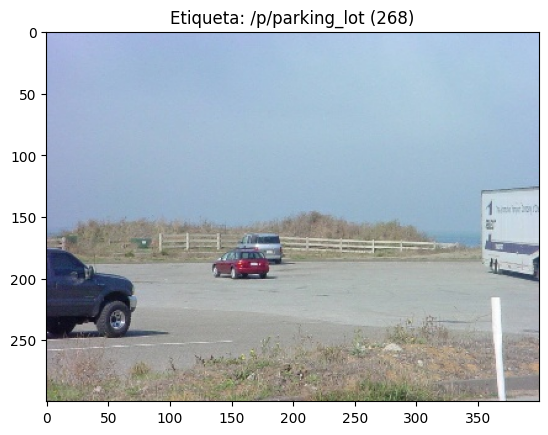

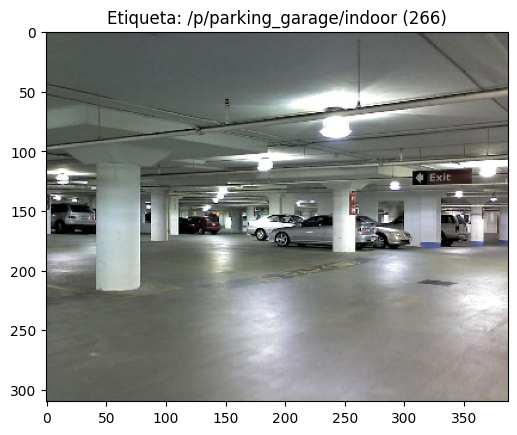

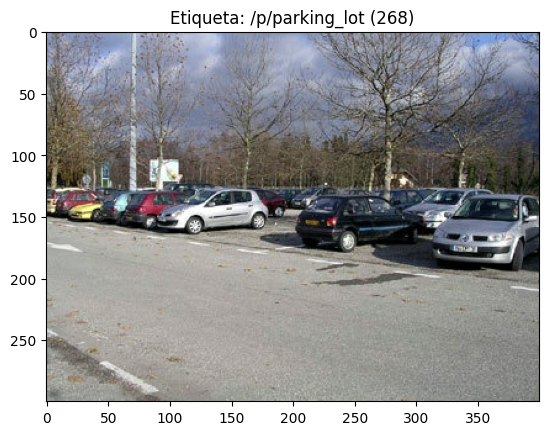

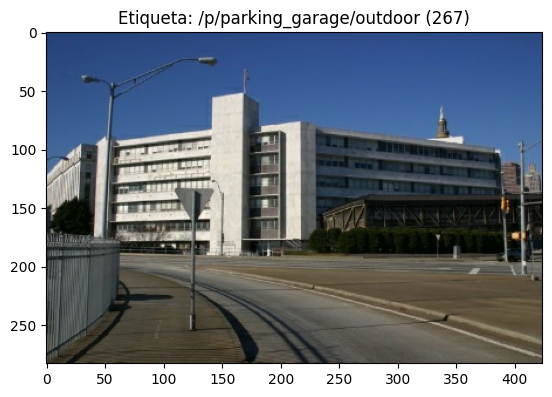

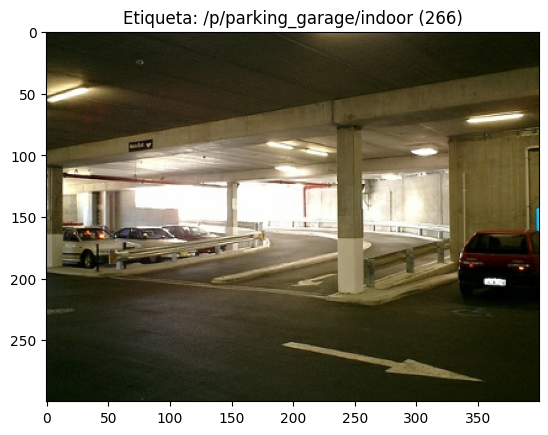

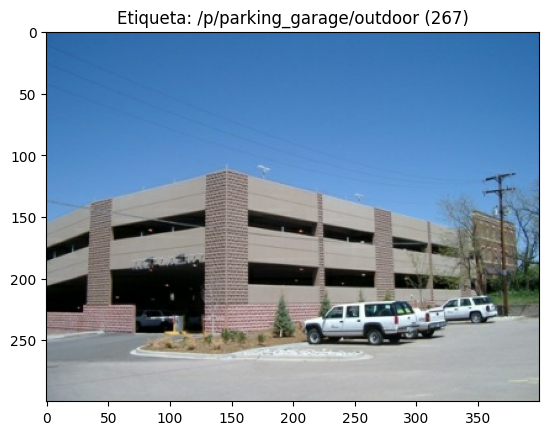

In [ ]:
# Verificar si la filtración funcionó correctamente y mostrar 2 imágenes de cada etiqueta
mostrar_por_etiqueta = 2
mostradas_por_etiqueta = {label: 0 for label in target_labels}

for datos_filtrados in datos_entrenamiento_filtrados:
    if mostradas_por_etiqueta[datos_filtrados['label'].numpy()] < mostrar_por_etiqueta:
        imagen = datos_filtrados['image']
        etiqueta = datos_filtrados['label']

        # Obtener el nombre y número de la etiqueta a partir del número de índice
        nombre_etiqueta = nombres_clases[etiqueta.numpy()]
        numero_etiqueta = etiqueta.numpy()

        # Imprimir el nombre y número de la etiqueta y mostrar la imagen
        plt.figure()
        plt.imshow(imagen.numpy())
        plt.title(f"Etiqueta: {nombre_etiqueta} ({numero_etiqueta})")
        plt.show()

        # Incrementar el contador de imágenes mostradas para esta etiqueta
        mostradas_por_etiqueta[etiqueta.numpy()] += 1

    # Verificar si se han mostrado suficientes imágenes para todas las etiquetas
    if all(cantidad >= mostrar_por_etiqueta for cantidad in mostradas_por_etiqueta.values()):
        break  # Salir del bucle si se han mostrado suficientes imágenes



## Comprobar el numero de ejemplos

Se imprimen el numero de datos de entrenamiento, validacion y prueba comprobando que son acordes con los datos de la pagina `KnowYourData` de `sun397`:

- Para parking_lot: 439 datos, 301 de entrenamiento, 87 de prueba y 51 de validacion

- Para parking_garage/outdoor: 111 datos, 76 de entrenamiento, 22 de prueba y 13 de validacion

- Para parking_garage/indoor: 100 datos, 65 de entrenamiento, 26 de prueba y 9 de validacion


In [ ]:

# Contar el número de ejemplos en el conjunto de entrenamiento después del filtro
num_ejemplos_entrenamiento = sum(1 for _ in datos_entrenamiento_filtrados)
print("Número de ejemplos en el conjunto de entrenamiento después del filtro:", num_ejemplos_entrenamiento)

# Contar el número de ejemplos en el conjunto de prueba después del filtro
num_ejemplos_pruebas = sum(1 for _ in datos_pruebas_filtrados)
print("Número de ejemplos en el conjunto de prueba después del filtro:", num_ejemplos_pruebas)

# Contar el número de ejemplos en el conjunto de validación después del filtro
num_ejemplos_validacion = sum(1 for _ in datos_validacion_filtrados)
print("Número de ejemplos en el conjunto de validación después del filtro:", num_ejemplos_validacion)



Número de ejemplos en el conjunto de entrenamiento después del filtro: 442
Número de ejemplos en el conjunto de prueba después del filtro: 135
Número de ejemplos en el conjunto de validación después del filtro: 73


## Configurar datos

Cada tipo de dato (entrenamiento, prueba y validacion) se procesa con la funcion que construimos, agrupa los datos en grupos de 16 (tamaño del lote) y los guarda en cache

In [ ]:
# Configurar el tamaño del lote
TAMANO_LOTE = 16

# Datos de entrenamiento filtrados
datos_entrenamiento_filtrados = datos_entrenamiento_filtrados.map(preprocesar)
datos_entrenamiento_filtrados = datos_entrenamiento_filtrados.batch(TAMANO_LOTE)
datos_entrenamiento_filtrados = datos_entrenamiento_filtrados.cache()

# Datos de prueba filtrados
datos_pruebas_filtrados = datos_pruebas_filtrados.map(preprocesar)
datos_pruebas_filtrados = datos_pruebas_filtrados.batch(TAMANO_LOTE)
datos_pruebas_filtrados = datos_pruebas_filtrados.cache()

# Datos de validación filtrados
datos_validacion_filtrados = datos_validacion_filtrados.map(preprocesar)
datos_validacion_filtrados = datos_validacion_filtrados.batch(TAMANO_LOTE)
datos_validacion_filtrados = datos_validacion_filtrados.cache()

# Obtener la forma de entrada de los metadatos
input_shape = (250, 250, 3)  # Tamaño después de la redimensión y normalización



## Mostrar imagenes procesadas

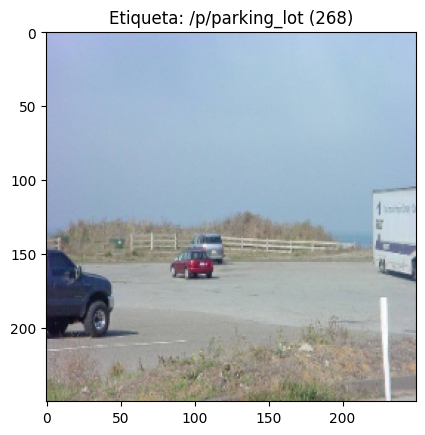

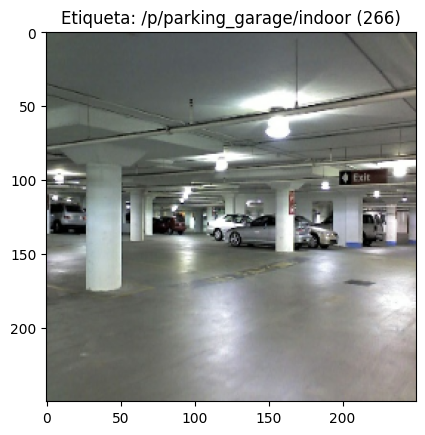

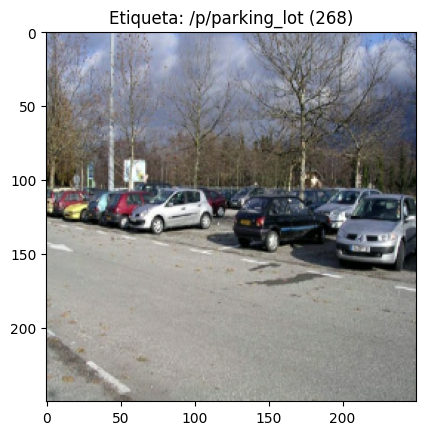

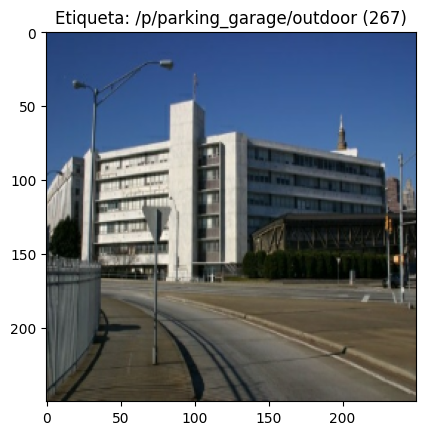

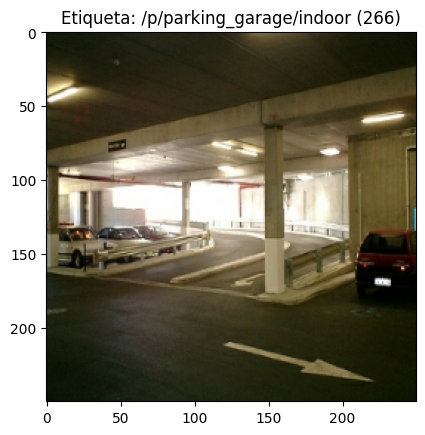

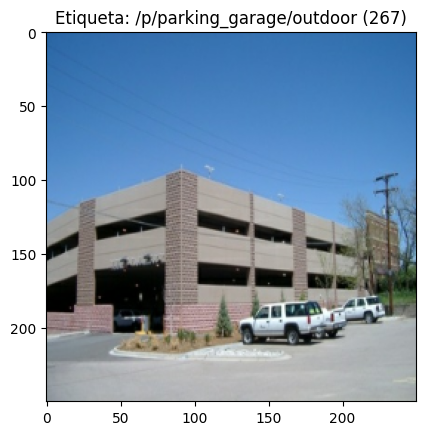

In [ ]:
# Obtener los nombres de las clases a partir del metadato
nombres_clases = metadatos.features['label'].names

# Verificar si la filtración funcionó correctamente y mostrar 2 imágenes de cada etiqueta
mostrar_por_etiqueta = 2
mostradas_por_etiqueta = {label: 0 for label in target_labels}

# Función para convertir la etiqueta numérica a su nombre
def obtener_nombre_etiqueta(etiqueta):
    return nombres_clases[int(etiqueta)]

# Iterar sobre los datos de entrenamiento filtrados
for datos_filtrados in datos_entrenamiento_filtrados:
    for i in range(datos_filtrados[0].shape[0]):  # Iterar sobre el tamaño del lote
        etiqueta = datos_filtrados[1][i].numpy()

        # Verificar si aún no se han mostrado suficientes imágenes para esta etiqueta
        if mostradas_por_etiqueta[etiqueta] < mostrar_por_etiqueta:
            imagen = datos_filtrados[0][i]

            # Imprimir el nombre y número de la etiqueta y mostrar la imagen
            plt.figure()
            plt.imshow(imagen.numpy())
            plt.title(f"Etiqueta: {obtener_nombre_etiqueta(etiqueta)} ({etiqueta})")
            plt.show()

            # Incrementar el contador de imágenes mostradas para esta etiqueta
            mostradas_por_etiqueta[etiqueta] += 1

    # Verificar si se han mostrado suficientes imágenes para todas las etiquetas
    if all(cantidad >= mostrar_por_etiqueta for cantidad in mostradas_por_etiqueta.values()):
        break  # Salir del bucle si se han mostrado suficientes imágenes


# Modelo

## Arquitectura:

La arquitectura sigue el diseño típico de una CNN para tareas de clasificación de imágenes. Comienza con capas de convolución y reducción de dimensionalidad para extraer características, seguidas de capas totalmente conectadas para realizar la clasificación final. La última capa utiliza la activación Softmax para asignar probabilidades a las clases en un problema de clasificación, como el rango de clases de interes es de 266 a 268 se define la ultima capa como 269 ya que esta capa espera un numero que define el numero de clases a considerar excluyendo el valor del numero.


## Compilacion:

Se utilizó el optimizador Adam, la función de pérdida de entropía cruzada categórica dispersa y se evaluará la precisión como métrica durante el entrenamiento y la evaluación. Se escogio la función de pérdida de entropía cruzada categórica dispersa ya que es apropiada para problemas de clasificación donde las etiquetas son enteros. Ayuda a minimizar la divergencia entre las distribuciones de probabilidad predichas y reales.

## Entrenamiento:

Se ejecuta el proceso de entrenamiento del modelo utilizando el conjunto de datos de entrenamiento proporcionado, con un número específico de épocas, y evalúa el rendimiento en el conjunto de datos de validación.

In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# Definir la arquitectura del modelo con nombre de entrada personalizado
modelo = models.Sequential([
    layers.Input(shape=input_shape, name='input_imagen'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(200, activation='relu'),
    layers.Dense(269, activation='softmax')
])



modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])


# Entrenar el modelo
epochs = 10

historia = modelo.fit(datos_entrenamiento_filtrados,
                      epochs=epochs,
                      validation_data=datos_validacion_filtrados)



Epoch 1/10
28/28 [==============================] - 45s 2s/step - loss: 3.2882 - accuracy: 0.6335 - val_loss: 1.0201 - val_accuracy: 0.6986
Epoch 2/10
28/28 [==============================] - 56s 2s/step - loss: 0.8992 - accuracy: 0.6810 - val_loss: 0.7873 - val_accuracy: 0.6986
Epoch 3/10
28/28 [==============================] - 56s 2s/step - loss: 0.8383 - accuracy: 0.6810 - val_loss: 0.7766 - val_accuracy: 0.6986
Epoch 4/10
28/28 [==============================] - 60s 2s/step - loss: 0.8380 - accuracy: 0.6810 - val_loss: 0.7710 - val_accuracy: 0.6986
Epoch 5/10
28/28 [==============================] - 56s 2s/step - loss: 0.8308 - accuracy: 0.6810 - val_loss: 0.7627 - val_accuracy: 0.6986
Epoch 6/10
28/28 [==============================] - 59s 2s/step - loss: 0.8224 - accuracy: 0.6810 - val_loss: 0.7533 - val_accuracy: 0.6986
Epoch 7/10
28/28 [==============================] - 50s 2s/step - loss: 0.8125 - accuracy: 0.6810 - val_loss: 0.7393 - val_accuracy: 0.6986
Epoch 8/10
28/28 [==

# Evaluar eficiencia

In [ ]:
# Evaluar el modelo en datos de prueba
resultado_pruebas = modelo.evaluate(datos_pruebas_filtrados)
print("Pérdida en datos de prueba:", resultado_pruebas[0])
print("Exactitud en datos de prueba:", resultado_pruebas[1])


In [ ]:
# Obtener las clases a partir de los nombres de las clases en el metadato
clases_metadato = metadatos.features['label'].names

# Imprimir las clases
print("Clases evaluadas por el modelo:")
for label in target_labels:
    print(f"{label}: {clases_metadato[label]}")

In [ ]:
import numpy as np

# Función para preprocesar una sola imagen
def preprocesar_imagen(imagen_path):
    imagen = tf.io.read_file(imagen_path)
    imagen = tf.image.decode_image(imagen, channels=3)
    imagen = tf.image.resize(imagen, (250, 250))
    imagen = tf.cast(imagen, tf.float32) / 255.0
    return imagen

# Función para realizar una predicción en una imagen
def predecir_clase(imagen_path, modelo, nombres_clases):
    imagen = preprocesar_imagen(imagen_path)
    imagen = tf.expand_dims(imagen, axis=0)  # Añadir dimensión del lote
    predicciones = modelo.predict(imagen)
    clase_predicha = np.argmax(predicciones[0])
    nombre_clase_predicha = nombres_clases[clase_predicha]
    return nombre_clase_predicha

# Ruta de una imagen de prueba
imagen_prueba_path = 'parking.jpeg'  # Reemplaza con la ruta de tu imagen

# Realizar una predicción en la imagen de prueba
clase_predicha = predecir_clase(imagen_prueba_path, modelo, nombres_clases)

# Imprimir el resultado
print(f'La imagen es clasificada como: {clase_predicha}')


1/1 [==============================] - 0s 168ms/step
La imagen es clasificada como: /p/parking_lot


# Exportacion e importacion del modelo entrenado:

## Guardar arquitectura y pesos:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Supongamos que ya tienes tu modelo entrenado (como 'modelo')

# Guardar la arquitectura del modelo en un archivo JSON
modelo_json = modelo.to_json()
with open('modelo_arquitectura.json', 'w') as json_file:
    json_file.write(modelo_json)

# Guardar los pesos del modelo en un archivo H5
modelo.save_weights('modelo_pesos.h5')


## Cargar Arquitectura y Pesos en otro Proyecto:

```
import tensorflow as tf
from tensorflow.keras import layers, models

# Cargar la arquitectura del modelo desde el archivo JSON
with open('modelo_arquitectura.json', 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = models.model_from_json(loaded_model_json)

# Cargar los pesos del modelo desde el archivo H5
loaded_model.load_weights('modelo_pesos.h5')

```

# Informacion extra


## Dataset SUN397:

- Descripción Detallada:
Contiene 108,753 imágenes de 397 categorías.
Utilizado en el benchmark Scene Understanding (SUN).
Configuraciones disponibles a través de TFDS, incluyendo particiones personalizadas y 10 particiones oficiales.
Imágenes redimensionadas a un máximo de 120,000 píxeles y codificadas como JPEG con calidad 72.
- Características del Conjunto de Datos:
  - file_name: Nombre del archivo (texto).
  - image: Imagen (formato uint8 con forma variable).
  - label: Etiqueta de clase (entero, 397 clases en total).
- Configuración por Defecto (TFDS):
Partición con divisiones aleatorias de tren/validación/prueba (70%/10%/20%).
Imágenes redimensionadas a un máximo de 120,000 píxeles, comprimidas con calidad JPEG 72.
Referencia:

Paper: "SUN database: Large-scale scene recognition from abbey to zoo" (Xiao et al., 2010).
Enlace: Proyecto SUN
Código Fuente: tfds.datasets.sun397.Builder
Tamaño de Descarga: 36.41 GiB